# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row, Window
from pyspark.sql.types import *
from pyspark.sql.functions import udf, desc, asc, struct
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import max as _max
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.feature import VectorAssembler

import pyspark.sql.functions as func

import datetime

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("spark app") \
        .getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [3]:
#reading in dataset sample
path = 'mini_sparkify_event_data.json'

data = spark.read.json(path)

In [4]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
# Statistics regarding the SessionId column and total records in the dataset
data.describe('sessionId').show()
print (data.count(), ' total records in dataset.')

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+

286500  total records in dataset.


In [6]:
def cleaning_and_preprocessing(data):
    '''
    Removes missing user Id values and creates hour, day, and churn columns
    
    INPUT
    data: user dataset
    
    OUTPUT
    data: cleaned dataset
    '''
    
    data = data.dropna(how='any', subset= ['userId', 'sessionId'])
    data = data.filter(data['userId'] != "")
    
    #Create new hour column from timestamp
    get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
    data = data.withColumn("hour", get_hour(data.ts))

    #Create new day column from timestamp
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)
    data = data.withColumn("day", get_day(data.ts))
    
    #Defining Churn
    cancellation_confirmation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

    data = data.withColumn("cancelled", cancellation_confirmation("page"))
    
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    
    data = data.withColumn("Churn", Fsum("cancelled").over(windowval))
    
    return data

In [7]:
data = cleaning_and_preprocessing(data)

In [82]:
def user_data_window(user_id, data=data):
    '''
    INPUT
    user_id (str): user id number
    data: dataset of all user activity
    
    OUTPUT
    user activity
    '''
    
    return data.select(["userId",
                        "firstname",
                        "ts", "page",
                        "level", "hour",
                        "Churn",
                        "cancelled",
                        "itemInSession",
                        "day"]).where(data.userId == "108").sort("ts").collect()
    
user_data_window("108", data)

### Data Exploration

In [9]:
dataset = data
dataset_pd = dataset.toPandas()

In [10]:
dataset_pd.describe()

,itemInSession,length,registration,sessionId,status,ts,cancelled,Churn
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05,278154.000000,278154.000000
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12,0.000187,0.161292
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09,0.013672,0.367801
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12,0.000000,0.000000
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12,0.000000,0.000000
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12,0.000000,0.000000
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12,0.000000,0.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12,1.000000,1.000000


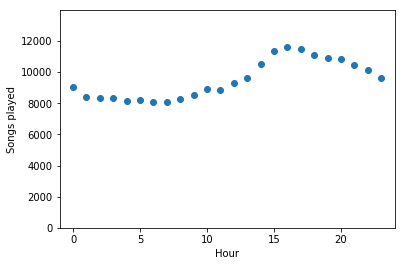

In [11]:
##Aggregate of songs play by hour of day
songs_in_hour = data.filter(data.page == "NextSong").groupby(data.hour).count().orderBy(data.hour.cast("float"))

songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [12]:
#Average songs played before cancellation
non_churned_user_songs = data.filter((data.Churn ==  0) & (data.page == 'NextSong')).groupby(data.userId).count()
churned_user_songs = data.filter((data.Churn ==  1) & (data.page == 'NextSong')).groupby(data.userId).count()

churned_user_songs_pd = churned_user_songs.toPandas()
non_churned_users_pd = non_churned_user_songs.toPandas()

In [13]:
print ('Average songs listened to by users who churned: ', churned_user_songs_pd['count'].mean())
print ('Median songs listened to by users who churned: ', churned_user_songs_pd['count'].median())
print ('Average songs played by users who stayed: ', non_churned_users_pd['count'].mean())
print ('Median songs played by users who stayed: ', non_churned_users_pd['count'].median())

percent_who_churned = len(churned_user_songs_pd) / (len(non_churned_users_pd) + len(churned_user_songs_pd))*100

print ('Percentage of users who churned: ', percent_who_churned) 

Average songs listened to by users who churned:  699.884615385
Median songs listened to by users who churned:  452.5
Average songs played by users who stayed:  1108.1734104
Median songs played by users who stayed:  747.0
Percentage of users who churned:  23.11111111111111


In [14]:
#Separating churn and non churned clients page count
non_churned_page_breakdown = data.filter(data.Churn ==  0).groupby(data.page).count()
non_churned_page_breakdown_pd = non_churned_page_breakdown.toPandas()

churned_page_breakdown = data.filter(data.Churn ==  1).groupby(data.page).count()
churned_page_breakdown_pd = churned_page_breakdown.toPandas()

In [15]:
non_churned_page_breakdown_pd

,page,count
0,Submit Downgrade,54
1,Thumbs Down,2050
2,Home,8410
3,Downgrade,1718
4,Roll Advert,2966
5,Logout,2673
6,Save Settings,252
7,About,439
8,Settings,1244
9,Add to Playlist,5488


In [16]:
churned_page_breakdown_pd

,page,count
0,Cancel,52
1,Submit Downgrade,9
2,Thumbs Down,496
3,Home,1672
4,Downgrade,337
5,Roll Advert,967
6,Logout,553
7,Save Settings,58
8,Cancellation Confirmation,52
9,About,56


In [17]:
## Deriving advertisements per song for churned and non churned users
churned_songs = churned_page_breakdown_pd[churned_page_breakdown_pd['page'] == 'NextSong']['count'].values[0]
churned_adverts = churned_page_breakdown_pd[churned_page_breakdown_pd['page'] == 'Roll Advert']['count'].values[0]

non_churned_songs = non_churned_page_breakdown_pd[non_churned_page_breakdown_pd['page'] == 'NextSong']['count'].values[0]
non_churned_adverts = non_churned_page_breakdown_pd[non_churned_page_breakdown_pd['page'] == 'Roll Advert']['count'].values[0]

print ('Songs listened to per advertisement for churned users: ',churned_songs/churned_adverts)
print ('Songs listened to per advertisement for non churned users: ',non_churned_songs/non_churned_adverts)


Songs listened to per advertisement for churned users:  37.6359875905
Songs listened to per advertisement for non churned users:  64.6372218476


In [18]:
#Churn rate for free vs paid users
non_churned_user_level = data.filter((data.Churn ==  0 )).groupby(data.level).count()
churned_user_level = data.filter((data.Churn ==  1 )).groupby(data.level).count()
non_churned_user_level_pd = non_churned_user_level.toPandas()
churned_user_level_pd = churned_user_level.toPandas()

free_level_churned = (non_churned_user_level_pd.loc[0]['count'] / non_churned_user_level_pd['count'].sum()) * 100
print ('% of non churned users who are on the free level: ', free_level_churned)


free_level_non_churned = (churned_user_level_pd.loc[0]['count'] / churned_user_level_pd['count'].sum()) * 100
print ('% of churned users who are on the free level: ',free_level_non_churned)


% of non churned users who are on the free level:  18.574735308
% of churned users who are on the free level:  27.612339515


In [19]:
churned_page_breakdown = data.select(['Churn', 'page']).filter((data.Churn == 1) & (~data['page'].isin(['NextSong',
                                                                                                        'Cancel',                                                                                                      'Cancellation Confirmation']))).sort('page')

churned_page_breakdown_pd = churned_page_breakdown.toPandas()

non_churned_page_breakdown = data.select(['Churn', 'page']).filter((data.page != 'NextSong') & (data.Churn == 0)).sort('page')

non_churned_page_breakdown_pd = non_churned_page_breakdown.toPandas()

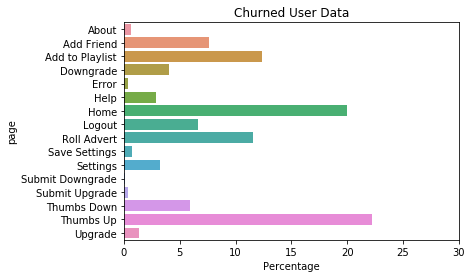

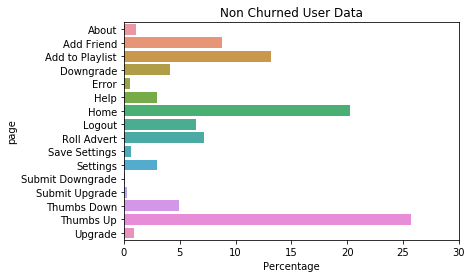

In [20]:
def plot_breakdown(data, title, column, xmax=30):
    '''
    Plots count distribution for given dataset
    
    INPUT
    data: user data(dataframe)
    title: plot title(Str)
    column: column of dataset to plot(str)
    xmax: x axis range(int)
    
    OUTPUT
    Count distribution plot
    '''
    ax = sns.barplot(y=data[column],
                     x=range(len(data[column])),
                     orient='h',
                     estimator=lambda x: len(x) / len(data[column]) * 100);
    ax.set(xlim=(0, xmax))
    ax.set(ylabel=column);
    ax.set(xlabel="Percentage");
    ax.set(title=(title + ' User Data'))
    
    plt.show()

plot_breakdown(churned_page_breakdown_pd, 'Churned', 'page')
plot_breakdown(non_churned_page_breakdown_pd, 'Non Churned', 'page')


In [21]:
churned_users = dataset_pd[dataset_pd['Churn'] == 1]
non_churned_users = dataset_pd[dataset_pd['Churn'] == 0]

In [22]:
def calculate_songs_per_session(data):
    '''
    INPUT
    data: pandas dataframe
    
    OUTPUT
    Song per session per user dataset
    '''
    logins = data[data['page'].isin(['Logout', 'Cancellation Confirmation'])].groupby('userId').count()['page']
    songs = data[data['page'] == 'NextSong'].groupby('userId').count()['page']
    
    return songs/logins

In [23]:
churned_sessions = calculate_songs_per_session(churned_users)
non_churned_sessions = calculate_songs_per_session(non_churned_users)

print ('Average songs played per session for churned users (before logging out or cancelling): ',churned_sessions.mean())
print ('Average songs played per session for non churned users (logging out): ',non_churned_sessions.mean())

Average songs played per session for churned users (before logging out or cancelling):  52.9407060289
Average songs played per session for non churned users (logging out):  70.9359912778


In [24]:
##Create datasaets of paid vs free user groups for churned and non churned users
churned_level_breakdown = data.select(['Churn', 'level']).filter((data.Churn == 1))
churned_level_breakdown_pd = churned_level_breakdown.toPandas()
                                                                   
non_churned_level_breakdown = data.select(['Churn', 'level']).filter((data.Churn == 0))
non_churned_level_breakdown_pd = non_churned_level_breakdown.toPandas()

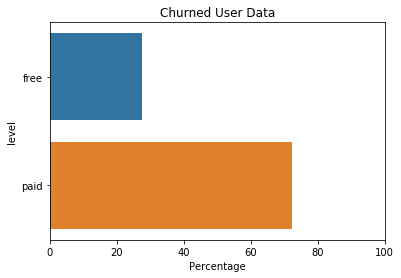

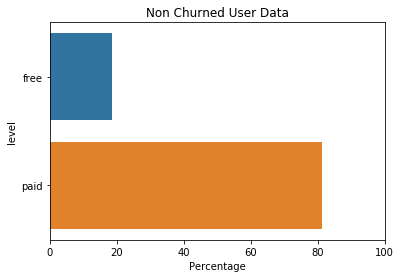

In [25]:
plot_breakdown(churned_level_breakdown_pd, 'Churned', 'level', xmax=100)
plot_breakdown(non_churned_level_breakdown_pd, 'Non Churned', 'level', xmax=100)

In [26]:
### Thumbs up distribution of churned users
churned_thumbs_up = data.select(['userId', 'page']).filter((data.Churn == 1) & (data.page.isin(['Thumbs Down',
                                                                                                'Thumbs Down'])))
churned_thumbs_up_pd = churned_thumbs_up.toPandas().groupby('userId').count()

churned_songs = data.select(['userId', 'page']).filter((data.Churn == 1) & (data.page == 'NextSong'))
churned_songs_pd = churned_songs.toPandas().groupby('userId').count()

In [27]:
churned_thumbs_up_pd.head()

,page
userId,
100001,2
100005,3
100006,2
100007,6
100009,8


In [28]:
churned_songs_pd.head()

,page
userId,
100001,133
100003,51
100005,154
100006,26
100007,423


In [29]:
### Thumbs up per song for churned users
(churned_thumbs_up_pd/churned_songs_pd).mean()

page    0.018969
dtype: float64

In [30]:
### Thumbs up distribution of non churned users
non_churned_thumbs_up = data.select(['userId', 'page']).filter((data.Churn == 0) & (data.page.isin(['Thumbs Down',
                                                                                                    'Thumbs Up'])))
non_churned_thumbs_up_pd = non_churned_thumbs_up.toPandas().groupby('userId').count()

non_churned_songs = data.select(['userId', 'page']).filter((data.Churn == 0) & (data.page == 'NextSong'))
non_churned_songs_pd = non_churned_songs.toPandas().groupby('userId').count()

In [31]:
### Tumbs up per song for non churned users
(non_churned_thumbs_up_pd/non_churned_songs_pd).mean()

page    0.066451
dtype: float64

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Aggregate per song dataframe

In [32]:
def data_preprocessing(data):
    
    '''
    Generates dataset with page visit per song listened for each user
    
    INPUT
    data: raw user record data
    
    OUTPUT
    dataset containing machine learning features and target
    '''

    ##Creating features and creating 'one hot encoded' dataset for selected page variables
    thumbs_up = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
    data = data.withColumn("Thumbs Up", thumbs_up("page"))

    thumbs_down = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
    data = data.withColumn("Thumbs Down", thumbs_down("page"))

    songs = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
    data = data.withColumn("Song", songs("page"))

    adverts = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
    data = data.withColumn("Advert", adverts("page"))

    add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
    data = data.withColumn("Add Friend", add_friend("page"))

    level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
    data = data.withColumn("Level", level("level"))

    userId = udf(lambda x: int(x), IntegerType())
    data = data.withColumn("User ID", userId("userId"))

    #Selecting feature and target from larger dataset
    model_data = data.select(['User ID','Thumbs up', 'Thumbs down', 'Song', 'Advert', 'Add Friend', 'Level', 'Churn'])

    #Grouping by users and counting total page interactions
    sums = model_data.groupBy('User ID').agg(_sum('Song').alias('Songs'),
                                             _sum('Thumbs Up').alias('Thumb Ups'),
                                             _sum('Thumbs Down').alias('Thumb Downs'),
                                             _sum('Advert').alias('Adverts'),
                                             _sum('Add Friend').alias('Add Friend'),
                                             _max('Level').alias('Level'),
                                             _max('Churn').alias('label'))


    #import pyspark.sql.functions as func

    per_song_df = sums

    #Finalizing features by extracing page visits per song for each user
    for col_name in per_song_df.columns[2:-2]:
        per_song_df = per_song_df.withColumn(col_name, func.round((per_song_df[col_name] / per_song_df.Songs), 5))
        
    return per_song_df

processed_data = data_preprocessing(data)

In [33]:
processed_data_pd = processed_data.toPandas()

In [34]:
processed_data_pd.head()

,User ID,Songs,Thumb Ups,Thumb Downs,Adverts,Add Friend,Level,label
0,148,398,0.07035,0.00754,0.08040,0.01759,0,0
1,85,3616,0.05310,0.01051,0.00913,0.01604,1,0
2,137,154,0.05195,0.00649,0.06494,0.05195,1,0
3,200001,115,0.08696,0.00870,0.02609,0.00000,0,1
4,65,2113,0.05253,0.00805,0.00379,0.02508,1,0


In [35]:
processed_data_pd.corr()

,User ID,Songs,Thumb Ups,Thumb Downs,Adverts,Add Friend,Level,label
User ID,1.000000,-0.060148,0.422182,0.268586,-0.018497,-0.015531,0.059212,0.080377
Songs,-0.060148,1.000000,0.010742,-0.062836,-0.435879,-0.118493,0.462415,-0.156110
Thumb Ups,0.422182,0.010742,1.000000,-0.084118,-0.090557,0.132000,0.016936,-0.026834
Thumb Downs,0.268586,-0.062836,-0.084118,1.000000,0.192721,0.038713,-0.088333,0.286762
Adverts,-0.018497,-0.435879,-0.090557,0.192721,1.000000,0.112013,-0.734470,0.191107
Add Friend,-0.015531,-0.118493,0.132000,0.038713,0.112013,1.000000,-0.123798,-0.025698
Level,0.059212,0.462415,0.016936,-0.088333,-0.734470,-0.123798,1.000000,-0.050863
label,0.080377,-0.156110,-0.026834,0.286762,0.191107,-0.025698,-0.050863,1.000000


In [36]:
processed_data_pd.describe()

,User ID,Songs,Thumb Ups,Thumb Downs,Adverts,Add Friend,Level,label
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,65391.013333,1013.813333,0.054756,0.011895,0.041113,0.021558,0.733333,0.231111
std,105396.477919,1104.960779,0.022879,0.010759,0.050472,0.021841,0.443203,0.422483
min,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,230.000000,0.044400,0.006970,0.003550,0.014150,0.000000,0.000000
50%,116.000000,675.000000,0.051190,0.009480,0.017840,0.018300,1.000000,0.000000
75%,100017.000000,1571.000000,0.060760,0.013240,0.068320,0.024530,1.000000,0.000000
max,300025.000000,8002.000000,0.227270,0.090910,0.333330,0.241380,1.000000,1.000000


### Vector Assembly

In [37]:
def vector_assembly(per_song_df):
    '''
    INPUT
    dataset containing user interactions per song listened to
    
    OUTPUT
    dataset containing label, and feature vector
    '''
    ml_data = per_song_df.select(['Thumb Ups',
                                  'Thumb Downs',
                                  'Adverts',
                                  'Add Friend',
                                  'Level',
                                  'label'])
    
    assembler = VectorAssembler(inputCols=['Thumb Ups',
                                           'Thumb Downs',
                                           'Adverts',
                                           'Add Friend',
                                           'Level'], outputCol="features")
    
    features_assembled = assembler.transform(ml_data)
    
    return features_assembled
    
assembled_data = vector_assembly(processed_data)

In [38]:
def data_split(data):
    '''
    Selects features vector and label and splits data
    INPUT
    dataset containinng features,, labels and vector assembles features
    
    OUPUT
    train, test, validation datasets
    '''
    label_and_features = assembled_data.select(['label', 'features'])
    
    train, test, validation = label_and_features.randomSplit([0.60, 0.20, 0.20], seed=12345)
    
    return train, test, validation

train, test, validation = data_split(assembled_data)

In [39]:
train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.07035,0.00754,...|
|    0|[0.05195,0.00649,...|
|    0|[0.0625,0.0,0.031...|
|    0|[0.04331,0.01181,...|
|    1|[0.04492,0.01418,...|
|    0|[0.09461,0.00888,...|
|    0|(5,[0,2],[0.03774...|
|    0|[0.05239,0.00815,...|
|    1|[0.04786,0.0089,0...|
|    0|[0.04762,0.00709,...|
|    1|[0.04545,0.01948,...|
|    1|[0.05422,0.0151,0...|
|    0|[0.04706,0.00392,...|
|    0|[0.05657,0.03434,...|
|    0|[0.08244,0.01075,...|
|    0|[0.04717,0.00943,...|
|    0|[0.04806,0.0093,0...|
|    0|[0.05035,0.01042,...|
|    0|[0.10714,0.0,0.14...|
|    0|[0.04879,0.031,5....|
+-----+--------------------+
only showing top 20 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Model Evaluation

In [121]:
#instantiate sparkcontext for array parallelization
#sc = SparkContext.getOrCreate()

def evaluate_model(preds):
    '''
    Evaluates models accruacy and area under roc
    
    INPUT
    preds: models set of predicitons and labels
    
    OUTPUT
    Accuracy
    Area Under ROC
    '''

    #instantiate multiclass evaluator
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    print("Accuracy: " + str(evaluator.evaluate(preds, {evaluator.metricName: "accuracy"})))
    
    #instantiate binaryclassification evaluator
    evaluator2 = BinaryClassificationEvaluator()
    print("Area Under ROC: " + str(evaluator2.evaluate(preds, {evaluator2.metricName: "areaUnderROC"})))
    


In [105]:
def cross_validation(model, paramGrid, folds=3):
    
    '''
    Cross_validation and optimization with f1 score
    
    INPUT
    model: instantiated model
    pramGrid: specific prameter grid for given model
    folds(int): number of folds to use for cross validaiton
    
    OUTPUT
    optimal cross_validated predictions dataset
    '''
    
    #evaluate cross validation best model using f1 score
    evaluator = MulticlassClassificationEvaluator(metricName="f1")
    
    cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=folds, seed=42)
    
    #train cvModel
    cvModel = cv.fit(train)
    
    #user best model to predict on the validation set
    best_model = cvModel.bestModel
    
    cvpredictions = best_model.transform(validation)
    
    return cvpredictions, cvModel

### Logistic Regression

In [88]:
#instantiate model
lr = LogisticRegression(maxIter=10, regParam=0.02)

#fit model to training data
lr = lr.fit(train)

#perform predictions on validation set
lr_results = lr.transform(validation)

evaluate_model(lr_results)

Accuracy: 0.6666666666666666
Area Under ROC: 0.7123745819397993


In [89]:
lr_results.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|[0.08696,0.0087,0...|[2.16577446164866...|[0.89713366724534...|       0.0|
|    1|[0.03952,0.00916,...|[1.61000914120519...|[0.83341265555678...|       0.0|
|    1|[0.04482,0.02852,...|[0.64722011376062...|[0.65638374852347...|       0.0|
|    0|[0.07985,0.0038,0...|[1.90051821187779...|[0.86995016575010...|       0.0|
|    1|[0.04846,0.00839,...|[1.68923420717429...|[0.84412342412076...|       0.0|
|    1|[0.04844,0.01038,...|[1.41234761908804...|[0.80413596075386...|       0.0|
|    1|[0.06015,0.01504,...|[1.17739537787809...|[0.76447916263551...|       0.0|
|    1|[0.07317,0.02439,...|[0.38992501849986...|[0.59626464889681...|       0.0|
|    0|[0.06818,0.0,0.0,...|[2.19219197342517...|[0.89954615299300...|       0.0|
|    0|[0.04793,

### Random Forests

In [90]:
#instantiate model
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=10, maxDepth=4)

#fit model to training data
rf = rf.fit(train)

#perform predictions on validation set
rf_results = rf.transform(validation)

evaluate_model(rf_results)

Accuracy: 0.6388888888888888
Area Under ROC: 0.645484949832776


In [91]:
rf_results.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|[0.08696,0.0087,0...|[7.16309974747474...|[0.71630997474747...|       0.0|
|    1|[0.03952,0.00916,...|[7.94940915948987...|[0.79494091594898...|       0.0|
|    1|[0.04482,0.02852,...|[6.77144130379424...|[0.67714413037942...|       0.0|
|    0|[0.07985,0.0038,0...|[9.40108399609118...|[0.94010839960911...|       0.0|
|    1|[0.04846,0.00839,...|[9.31320520821239...|[0.93132052082123...|       0.0|
|    1|[0.04844,0.01038,...|[8.15377715668875...|[0.81537771566887...|       0.0|
|    1|[0.06015,0.01504,...|[5.16070632798574...|[0.51607063279857...|       0.0|
|    1|[0.07317,0.02439,...|[7.82261108989050...|[0.78226110898905...|       0.0|
|    0|[0.06818,0.0,0.0,...|[7.74898663357715...|[0.77489866335771...|       0.0|
|    0|[0.04793,

### Gradient Boosted Trees

In [126]:
#instantiate model
gbt = GBTClassifier(maxIter=15, maxDepth=4)

#fit model to training data
gbt = gbt.fit(train)

In [127]:
#perform predictions on validation set
gbt_results = gbt.transform(validation)

evaluate_model(gbt_results)

Accuracy: 0.6388888888888888
Area Under ROC: 0.6588628762541806


With arbitrary hyper parameters and zero tuning, it appears the Logistic Regression model returns the best accuracy. However, all the accuracies are below the benchmark of 0.77 (if the model were to predict a label 0 for all users).

Cross validation and hyper parameter refinement will be needed.

## Refinement with Cross Validation

Optimizing for f1 score

### Logistic Regression

#### Validation Results

In [108]:
#instantiate random forest classifier
lr = LogisticRegression()

#build paramgrid
paramGrid = (ParamGridBuilder().addGrid(lr.maxIter, [10, 20, 30]).addGrid(lr.regParam, [0.01, 0.02, 0.03]).build())

##Cross validate on training model and display results of trained model when used to predict on the validation dataset
cvpredictions, cvModel = cross_validation(lr, paramGrid)

#store best model
lr_best_model = cvModel.bestModel

#evaluates optimized model's accuracy on the validation
evaluate_model(cvpredictions)

Accuracy: 0.6388888888888888
Area Under ROC: 0.7123745819397993


In [109]:
print ('Average f1 for each paramMap')
cvModel.avgMetrics

Average f1 for each paramMap


[0.740988579675596,
 0.7246296083177839,
 0.7246296083177839,
 0.7526313326372404,
 0.736794320386924,
 0.736794320386924,
 0.7526313326372404,
 0.736794320386924,
 0.736794320386924]

#### Test Set Results

In [110]:
#predict on test set with best model
test_predictions = lr_best_model.transform(test)
evaluate_model(test_predictions)

Accuracy: 0.7962962962962963
Area Under ROC: 0.7283950617283953


In [111]:
test_predictions.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0531,0.01051,0...|[1.59021158528745...|[0.83064586955083...|       0.0|
|    0|[0.05253,0.00805,...|[1.86596598850006...|[0.86599081831990...|       0.0|
|    1|(5,[0,2],[0.05882...|[1.05296637724215...|[0.74134411806341...|       0.0|
|    0|[0.0316,0.00948,0...|[1.54293616883319...|[0.82389115245793...|       0.0|
|    0|[0.07073,0.00366,...|[1.86849244715931...|[0.86628374465537...|       0.0|
|    0|[0.05296,0.01382,...|[1.48578579545490...|[0.81544490082297...|       0.0|
|    0|[0.08343,0.00771,...|[1.69329760846052...|[0.84465733536995...|       0.0|
|    0|[0.06132,0.00943,...|[1.94040538855250...|[0.87439667290433...|       0.0|
|    0|[0.03636,0.00909,...|[1.89607547809727...|[0.86944670207453...|       0.0|
|    0|[0.05756,

### Random Forest

#### Validation Results

In [112]:
#instantiate random forest classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

#build paramgrid
paramGrid = (ParamGridBuilder().addGrid(rf.maxDepth, [3, 4]).addGrid(rf.numTrees, [10, 15, 20]).build())

##Cross validate on training model and display results of trained model when used to predict on the validation dataset
cvpredictions, cvModel = cross_validation(rf, paramGrid)

#store best model
rf_best_model = cvModel.bestModel

#evaluates optimized model's accuracy on the validation
evaluate_model(cvpredictions)

Accuracy: 0.6388888888888888
Area Under ROC: 0.6538461538461539


In [113]:
print ('Average f1 for each paramMap')
cvModel.avgMetrics

Average f1 for each paramMap


[0.729951589835254,
 0.7231498638648688,
 0.7096338632452995,
 0.7199274896709917,
 0.7243644858767371,
 0.705657255058165]

The best hyper parameters: maxDepth = 4, numTrees = 10

#### Test Results

In [114]:
#predict on test set
test_predictions = rf_best_model.transform(test)
evaluate_model(test_predictions)

Accuracy: 0.8148148148148148
Area Under ROC: 0.6814814814814814


In [115]:
test_predictions.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0531,0.01051,0...|[8.60999549435698...|[0.86099954943569...|       0.0|
|    0|[0.05253,0.00805,...|[8.98183481036276...|[0.89818348103627...|       0.0|
|    1|(5,[0,2],[0.05882...|[7.55122166584631...|[0.75512216658463...|       0.0|
|    0|[0.0316,0.00948,0...|[7.67813371571804...|[0.76781337157180...|       0.0|
|    0|[0.07073,0.00366,...|[8.97486963623341...|[0.89748696362334...|       0.0|
|    0|[0.05296,0.01382,...|[8.50736555208166...|[0.85073655520816...|       0.0|
|    0|[0.08343,0.00771,...|[8.43375788728584...|[0.84337578872858...|       0.0|
|    0|[0.06132,0.00943,...|[8.97486963623341...|[0.89748696362334...|       0.0|
|    0|[0.03636,0.00909,...|[8.67813371571804...|[0.86781337157180...|       0.0|
|    0|[0.05756,

### Gradient Boosted Trees

#### Validation Results

In [116]:
#instantiate gbt classifier
gbt = GBTClassifier()

#build param grid
paramGrid = (ParamGridBuilder().addGrid(gbt.maxDepth, [4, 5]).addGrid(gbt.maxIter, [10, 20]).build())

#perform cross validation using f1 evaluator metric
cvpredictions, cvModel = cross_validation(gbt, paramGrid)

#store best model
gbt_best_model = cvModel.bestModel

#evaluates optimized model's accuracy on the validation
evaluate_model(cvpredictions)

Accuracy: 0.6388888888888888
Area Under ROC: 0.6672240802675585


In [117]:
print ('Average f1 for each paramMap')
cvModel.avgMetrics

Average f1 for each paramMap


[0.7030956041200375, 0.704024479095462, 0.7019973364022611, 0.6934895532567968]

#### Test Set Results

In [118]:
#predict on test set
test_predictions = gbt_best_model.transform(test)
evaluate_model(test_predictions)

Accuracy: 0.7037037037037037
Area Under ROC: 0.5679012345679014


In [119]:
test_predictions.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0531,0.01051,0...|[1.30985553778514...|[0.93211942764750...|       0.0|
|    0|[0.05253,0.00805,...|[0.77044480878893...|[0.82359401222448...|       0.0|
|    1|(5,[0,2],[0.05882...|[1.71596176902962...|[0.96868746525303...|       0.0|
|    0|[0.0316,0.00948,0...|[-0.4313858124450...|[0.29676059923517...|       1.0|
|    0|[0.07073,0.00366,...|[1.42840202427036...|[0.94566932889951...|       0.0|
|    0|[0.05296,0.01382,...|[1.05767346052155...|[0.89238589411642...|       0.0|
|    0|[0.08343,0.00771,...|[1.11420452584733...|[0.90277180318085...|       0.0|
|    0|[0.06132,0.00943,...|[1.15447410005878...|[0.90961541859787...|       0.0|
|    0|[0.03636,0.00909,...|[0.96712445747112...|[0.87371896511770...|       0.0|
|    0|[0.05756,

## Conclusion

#### GBT Classifier

```Validation accuracy```: 0.6388

```Cross Validation Best F1 Score```: 0.7040

```Best Parameters```: maxDepth: 5, maxIter: 10

```Test accuracy```: 0.7037

GBT classifier has underperformed compared to teh simpler models used. THis may be an issue with the amount of data in the sample being used to train.

#### Logistic Regression Classifier

```Validation accuracy```: 0.6388

```Cross Validaiton Best F1 Score```: 0.7526

```Best Parameters```: maxIter: 10, regParam: 0.01

```Test set accuracy```: 0.7962

Cross Validation only slightly improved accuracy on the validation dataset.

#### Random Forest Classifier

```Validation accuracy```: 0.6388

```Cross Validation Best F1 Score```: 0.7299

```Best Parameters```: maxDepth: 3, numTrees: 10

```Test accuracy```: 0.8148

Cross Validation did not improve validaiton set accuracy. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.